# Cell DECODER Toolbox

## Introduction
The Cell DEep learning and COmputational DEscriptoR (DECODER) toolbox is a set of high-level Python modules for applying deep learning to image analysis and phenotypic profiling in cell biology. It is currently built on the [Microsoft Cognitive Toolkit (CNTK)](https://github.com/Microsoft/CNTK). This toolbox is not meant to replace popular deep learning APIs, such as [Keras](https://keras.io), which provide extensive tools and support for building custom neural networks. Rather, Cell DECODER is aimed at cell biologists who wish to apply deep learning models trained on biological datasets to their own images with minimal additional traning or customization.

## Deep learning workflow
There are five major stages to any learning algorithm. The Cell DECODER toolbox takes care of most of these processes within minimal user input required. These stages include: 
1. Reading data
2. Pre-processing data
3. Model creation
4. Model training
5. Model evaluation

There are multiple factors to consider within each stage, which we will not addres here. For more information, we direct the reader to the following resources:

* [Nature Review: Deep Learning](http://www.nature.com/nature/journal/v521/n7553/full/nature14539.html)
* [edX course: Deep Learning Explained](https://www.edx.org/course/deep-learning-explained-microsoft-dat236x)
* [Coursera: Deep Learning](https://www.coursera.org/specializations/deep-learning)
* [Coursera: Machine learning](https://www.coursera.org/learn/machine-learning)
* [deeplearning.ai](https://www.deeplearning.ai/)
* [CNTK tutorials](https://docs.microsoft.com/en-us/cognitive-toolkit/tutorial/tutorial#cntk-tutorial-getting-started)

Running Cell DECODER version 0.1.0


Loading BokehJS ...


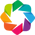

In [1]:
# cntk_imports.py
#
# Copyright (c) 2017 Jeffrey J. Nirschl
# All rights reserved
# All contributions by Jeffrey J. Nirschl in
# the laboratory of Erika Holzbaur at the
# University of Pennsylvania.
#
# Distributable under an MIT License
# ======================================================================
# Last updated JN 20170922

# Standard library imports 
from __future__ import print_function
import os
import re
import sys
import time
import numpy as np
import pandas as pd

# Third-party imports
import cv2
from bokeh.io import output_notebook, show
import holoviews as hv
import matplotlib.pyplot as plt

# Import cell_decoder
import cell_decoder

# Configure plotting libraries
%matplotlib inline
output_notebook()
hv.notebook_extension('bokeh')


## Stage 1: Reading data
First, we will read our data in the form of a 'mapfile'. This is a comma or tab-delimited text document that specifies the path to each image and the corresponding label, as shown below. Note that the labels are indexed from zero not one.

```text
/path/to/my/images/HeLa_001.png    0
/path/to/my/images/USOS_002.png    1
/path/to/my/images/HeLa_002.png    0
```

If you don't have a mapfile yet, don't worry! Cell DECODER can create a mapfile from a directory of images.
```python
my_directory = '/path/to/my/images/'
mapfile = cell_decoder.io.mapfile_utils.create_mapfile(my_directory)
```

Let's take a look at the [Human Protein Atlas](https://www.proteinatlas.org/cell) dataset, which was used to train Cell Decoder. The subset we use here contains 22 different cell lines, all stained for DNA (DAPI), microtubules (alpha-Tubulin DM1A), or the endoplasmic reticulum (calnexin/ calreticulin).

In [2]:
import plotly.plotly as py
from plotly.offline import init_notebook_mode, plot, iplot # download_plotlyjs,
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

filepath = os.path.join(os.path.dirname(cell_decoder.__file__), 'data', 'datasets',
                        'human_protein_atlas','cell_lines',
                        'HumanProteinAtlas_learn_cell_lines_info.csv')
df_cell_lines = pd.read_csv(filepath, header=0)
df_cell_lines.ix[0:21,:]

Cell_ID         Name   Age     Sex  \
0       1.0        A-431  85.0  Female   
1       2.0         A549  58.0    Male   
2       3.0         AF22  36.0  Female   
3       4.0    ASC TERT1   NaN  Female   
4       5.0           BJ   NaN    Male   
5       6.0       CACO-2  72.0    Male   
6       7.0      HEK 293   NaN  Female   
7       8.0  HUVEC TERT2   NaN  Female   
8       9.0        HaCaT   NaN    Male   
9      10.0         HeLa  31.0  Female   
10     11.0       Hep G2  15.0    Male   
11     12.0         MCF7  69.0  Female   
12     13.0         NB-4  23.0  Female   
13     14.0         PC-3  62.0    Male   
14     15.0        REH**  15.0  Female   
15     16.0        RH-30  17.0    Male   
16     17.0          RT4  63.0    Male   
17     18.0      SH-SY5Y   4.0  Female   
18     19.0    SK-MEL-30  67.0    Male   
19     20.0         SiHa  55.0  Female   
20     21.0       U-2 OS  15.0  Female   
21     22.0     U-251 MG   NaN    Male   

                                      Tissue  \
0                                       Skin   
1                                       Lung   
2                                      Brain   
3                                    Sarcoma   
4                                 Fibroblast   
5                                  Abdominal   
6   Renal, urinary, male reproductive system   
7                                Endothelial   
8                                       Skin   
9         Breast, female reproductive system   
10                                 Abdominal   
11        Breast, female reproductive system   
12                                   Myeloid   
13  Renal, urinary, male reproductive system   
14                                  Lymphoid   
15                                   Sarcoma   
16  Renal, urinary, male reproductive system   
17                                     Brain   
18                                      Skin   
19        Breast, female reproductive system   
20                                   Sarcoma   
21                                     Brain   

                                          Description  \
0                      Epidermoid carcinoma cell line   
1                            Lung carcinoma cell line   
2     iPS derived Neuroepithelia stem (NES) cell line   
3   Adipose tissue-derived mesenchymal stem cell line   
4                       Adherent fibroblast cell line   
5                      Colon adenocarcinoma cell line   
6   Embryonal kidney cell line, transformed by ade...   
7                Umbilical vein endothelial cell line   
8                              Keratinocyte cell line   
9        Cervical epithelial adenocarcinoma cell line   
10                 Hepatocellular carcinoma cell line   
11         Metastatic breast adenocarcinoma cell line   
12       Acute promyelocytic leukemia (APL) cell line   
13  Metastatic poorly differentiated prostate aden...   
14  Pre-B cell leukemia cell line (ALL, first rela...   
15              Metastatic rhabdomyosarcoma cell line   
16  Urinary bladder transitional cell carcinoma ce...   
17  Metastatic neuroblastoma, clonal subline of ne...   
18            Metastatic malignant melanoma cell line   
19  Cervical squamous cell carcinoma cell line, in...   
20                             Osteosarcoma cell line   
21                             Glioblastoma cell line   

                                            Reference            Origin  \
0    Giard et al., J Natl Cancer Inst 51: 1417 (1973)              Skin   
1    Giard et al., J Natl Cancer Inst 51: 1417 (1973)              Lung   
2                   Falk et al., PLoS One 7(1) (2012)              Skin   
3   Wolbank S. et al., Tissue Eng Part A: Jul;15(7...    Adipose tissue   
4      Bodnar AG., et al. Science 279: 349-352 (1998)          Foreskin   
5   Fogh J., et al. J. Natl. Cancer Inst. 58: 209 ...             Colon   
6            Graham et al., J Gen Virol 36: 59 (1977)  Embryonal kidney   
7                   

### Create a DataStruct object
First, we create a new instance of a DataStructure, which will hold all of our information (mapfiles, labels, deep learning models etc.). You can customize any of the following classes: DataStructParameters, TransformParameters, or LearningParameters or you can use the default settins. It will use default settings if you leave the parentheses empty. Notice that it will performs error checks to make sure everything goes smoothly. 

In [3]:
# Initiate a DataStruct object, which contains all of the information
from cell_decoder.io import DataStruct

mapfile = os.path.normpath(os.path.join(cell_decoder.__file__, '../mapfiles/human_protein_atlas/cell_lines',
                                        'all_cells_mapfile.tsv'))

data_struct = DataStruct(mapfile)

Checking a random 0.50% of mapfile to ensure files exist.



### Visualizing the images of each cell type
Let's take a look at some of these images from the Human Protein Atlas. The original images (2048x2048) were acquired on a confocal microscope using a 100x objective. We resized the images to ~32x magnification or 250nm per pixel(655x655). The network accepts a 224x224 image, and at this resolution a single random crop will capture cellular/ microenvironment context while retaining the resolution to identify subcellular structures. 

During training the images are randomly resized from a uniform random range [0.4, 0.875] where 1 represents resizing the full image 655x655 to 224x224. A value of 0.5 represents taking a random crop of 262x262 and then resizing to 224x224. As we show later, networks trained on images between 16 - 32x does not limit application to that magnification range

### Figure 1. Images from the Human Protein Atlas
Each image is stained for DNA (DAPI), microtubules (alpha-tubulin, clone DM1A), and the endoplasmic reticulum (calnexin or calreticulin). Here, we resize the 655x655 image to 224x224 to visualize the entire field.

Image credit:  Human Protein Atlas

In [4]:
# The DataStruct class can automatically read a random image from each class/ label for quick visualization
hv_img = data_struct.plot_unique()
hv.Layout(hv_img[0:4]).cols(2)

Checking a random 1.00% of mapfile to ensure files exist.



:Layout
   .RGB.A_0 :RGB   [x,y]   (R,G,B)
   .RGB.A_1 :RGB   [x,y]   (R,G,B)
   .RGB.A_2 :RGB   [x,y]   (R,G,B)
   .RGB.A_3 :RGB   [x,y]   (R,G,B)

## Stage 2: Preprocessing data
Preprocessing data is an important step for learning algorithms. For images, this generally involves subtracting the mean (centering) and linearly normalizing the pixel intensity to a unit range [0-1] (scaling). Here, we will compute the image mean so that we can subtract it later. The data will be automatically scaled from [0-255] to [0-1] as each image is read.

In [5]:
# Compute image mean
image_mean = data_struct.compute_image_mean(data_aug=True, nargout=True, save_img=False)

Processed 1 images.
Processed 101 images.



In [6]:
# Display image mean
%opts RGB [xaxis=None yaxis=None]
hv.RGB(image_mean, label='Mean over all images')

:RGB   [x,y]   (R,G,B)

## Stage 3: Model creation
Here, we will create a reader object that will read and shuffle images in our mapfile. We will feed the output to the network during training.

In the cell below, we create a model from our data_struct that contains the neural network architecture and the inputs/ labels.

In [7]:
# Create reader
from cell_decoder.config import TransformParameters
train_params = TransformParameters()
train_mb_source = data_struct.create_mb_source(train_params,
                                               is_training=True)

Subtracting mean pixel values.



In [8]:
# Create model
model_dict = data_struct.create_model()

## Stage 4. Model training
Here, we traing the model for a pre-specific number of epochs (one full pass through all images) or until a pre-defined stopping criteria. We will leave the settings to the defaults (100 epochs). Cell DECODER also automatically splits the data into train, test, and held-out datasets. During training, it performs cross-validation to get a sense of how well the algorithm will generalization. The held-out test dataset is never used during training.

In [9]:
# Train model
net = data_struct.train_model(model_dict)

## Stage 5. Model Evaluation
One of the last step in developing a new learning algorithm is to test the model performance on a held-out test set. The held-out test set represents a small sample of data that was randomly removed from the dataset before training, and which was never used during training. This is the gold-standard for measuring generalization. If the model simply 'memorized' the training images, it would not perform well on this held-out test set. 

TODO

## Stage 6. Exploration
Now we can apply our trained model to new images in order to predict the cell type. In itself, this may not be very useful to many biologists.

Alternatively, we can remove the final classification layer encoding the probability of cell type to leave a high dimensional vector encoding object models. These object models are representations that the algorithm learned were useful to predict cell type. Our hypothesis is that these hierarchical represenations may also be useful to discover phenotypes in different biological datasets.

The output of the truncated network is a vector with 2048 dimensions that represent features or object models useful to predict cell type in the next layer. In other words, the image cell type is encoded by a vector 2048 numbers. This might seem like a large number, but if we consider of each RGB pixel of the original image as a dimension then the original image could be stretched out into a vector with 150528 dimensions (224x224x3).

### Dimensionality reduction
Since we live in a 3D world, it is difficult to think in higher dimensional spaces such as 4, 5, or 6D, let alone 1000+ dimensions. However, the high-dimensional representation encodes useful information that can't be appreciated in 2 dimesions. In order to preserve the structure in high-dimensional space, we can project or embed the data into a lower dimensional space in a way that retains some properties of the original data structure. This is known as **dimensionality reduction**. There are linear methods to reduce dimensionity (such as PCA, Isomap, LLE, etc) and nolinear methods (such as tSNE). We use [tSNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), an algorithm developed by Laurens van der Maaten in Geoff Hinton's laboratory because it is particularly good for visualizing high dimensional datasets.

### Data exploration
First, let's load the original feature vector from the final pooling layer (2048 vector).

In [10]:
filepath = os.path.join(os.path.dirname(cell_decoder.__file__), 'data',
                        'profiling','cells',
                        'Res50_81_cells_featvec.csv')
df_features = pd.read_csv(filepath, header=0)
df_labels = pd.read_csv(filepath.replace('featvec','labels'), header=None)

### Table 1. Raw output vectors
I show the first five rows of output below. Each row represents one held-out test image that the network has never 'seen' during training. Each column represents the output of a single hidden neuron in the final pooling layer, before predicting cell type. A separate column vector stores the cell type labe, where each row has a number indicating the true cell type. 

In [11]:
df_features = df_features.rename(columns={elem:'{0:d}'.format(elem) for elem in range(df_features.shape[1])})
df_features.head()

0         1         2         3         4         5         6  \
0  0.084302  0.154839  0.009414  0.020913  0.122875  0.233634  0.057160   
1  0.007604  0.068145  0.069298  0.004188  0.123070  0.058005  0.023953   
2  0.611736  0.108058  0.241693  0.136481  0.584276  0.154968  0.173054   
3  0.148555  0.013761  0.063644  0.013419  0.168282  0.017468  0.174046   
4  0.042322  0.085183  0.272734  0.105588  0.012891  0.142194  0.308631   

          7         8         9    ...         2038      2039      2040  \
0  0.084188  0.320695  0.021273    ...     0.108520  0.132985  0.010325   
1  0.206033  0.039807  0.008941    ...     0.006154  0.374445  0.109889   
2  0.041593  0.037763  0.007293    ...     0.023052  0.306711  0.017214   
3  0.019093  0.046945  0.017764    ...     0.003772  0.095729  0.066471   
4  0.033287  0.190878  0.165747    ...     0.017866  0.085989  0.072298   

       2041      2042      2043      2044      2045      2046      2047  
0  0.103261  0.238458  0.039634  0.039455  0.021009  0.015416  0.008971  
1  0.106834  0.000000  0.041856  0.000105  0.033367  0.130573  0.252295  
2  0.073946  0.308839  0.391796  0.335775  0.060879  0.025462  0.007438  
3  0.165391  0.271682  0.329735  0.158321  0.093476  0.265996  0.237047  
4  0.169635  0.073919  0.210206  0.002546  0.058466  0.088539  0.286553  

[5 rows x 2048 columns]

### tSNE embedding
I reduced the dimensionality of this dataset usign the tSNE algorithm.
The tSNE algorithm reduces dimensionality in a way that preserves 
high-dimensional structure and it does not use the true cell type label.

### Table 2. tSNE embedding in 8 dimensions
The table below shows the output of tSNE where I reducedd the original 2048 dimensional vector into 8 dimensions. I concatenated the cell type label to the array after dimensionality reduction.

In [12]:
filepath = os.path.join(os.path.dirname(cell_decoder.__file__), 'data',
                        'profiling','cells',
                        'Res50_81_cells_mapped_labels.csv')
df = pd.read_csv(filepath, header=None)
df = df.rename(columns={elem:'tsne_{0:d}'.format(elem) for elem in range(df.shape[1])})
df = df.rename(columns={'tsne_8':'label'})
df.head()

tsne_0   tsne_1   tsne_2   tsne_3  tsne_4   tsne_5   tsne_6   tsne_7  label
0 -5.5215 -10.6180  11.4390   2.8789 -24.248  12.7960   2.6656   7.2754     21
1 -4.6039   4.3757   7.2063  -1.8260 -13.170  28.4400   1.6065 -13.9940      9
2  5.5324 -17.4550  29.2170  14.8390 -20.439   3.0098  -3.9602   4.6313     15
3 -6.2311   5.1129  -4.2056 -17.4060  15.426  -3.1605 -10.5280   4.0444      5
4  3.0125  -1.9737 -28.0980  -0.4983   9.056  -7.4803  19.5500   6.4924     11

## Phenotypic profiling
Let's visualize the first three dimensions using a 3D scatterplot.

In [14]:
fig = cell_decoder.visualize.plot.prepare_plotly(df)
py.iplot(fig, filename='Phenotypic Profiling')